In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
from tqdm import tqdm

#not in scope of this course
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader


In [ ]:
train_dataset = CIFAR10(".", download = True, train = True, transform = T.ToTensor())
test_dataset = CIFAR10(".", download = True, train = False, transform = T.ToTensor())

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
print("Class names:", train_dataset.classes)
print("\nNumber of classes:", len(train_dataset.classes))
print("\nClass to index:", train_dataset.class_to_idx)

print("\ntrain_dataset.data.shape",train_dataset.data.shape)
print("\ntest_dataset.data.shape",test_dataset.data.shape)
## 50k images for train
## 10k images for test
## 32*32*3 images


Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Number of classes: 10

Class to index: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

train_dataset.data.shape (50000, 32, 32, 3)

test_dataset.data.shape (10000, 32, 32, 3)


In [ ]:
bs = 64

train_loader = DataLoader(train_dataset, batch_size = bs)
test_loader = DataLoader(test_dataset, batch_size = bs)



print("Number of batches for train: ",len(train_loader))
print("Batch size for train: ",train_loader.batch_size)

print("Number of batches for test: ",len(test_loader))
print("Batch size for test: ",test_loader.batch_size)

print()
for images, labels in train_loader:
    print("Images: ",images.shape)
    print("Labels: ",labels.shape)
    break



Number of batches for train:  782
Batch size for train:  64
Number of batches for test:  157
Batch size for test:  64

Images:  torch.Size([64, 3, 32, 32])
Labels:  torch.Size([64])


## $\color{lightblue}{\text{Why from 32×32×3 to 3×32×32?}}$
## $\color{lightblue}{\text{PyTorch convention is (batch\_size, channels, height, width)}}$

# Tasks
#1) Create at least 4 layers NN to classify the dataset     
#2) Train the neural network on train dataset       
#3) Show the training loss      
#4) Calculate the accuracy on test set      
#5) Show a few incorrectly classified samples       
#6) Calculate class-wise accuracy (implement the function yourself)     

# Neural Network

---



In [ ]:
# # Define the neural network
# class My_NN(nn.Module):
#     def __init__(self, ni, nh1, nh2, nh3, no):
#         super(My_NN, self).__init__()
#         self.layer1 = nn.Linear(ni, nh1)
#         self.layer2 = nn.Linear(nh1, nh2)
#         self.layer3 = nn.Linear(nh2, nh3)
#         self.layer4 = nn.Linear(nh3, no)

#     def forward(self, x):
#         x = x.view(-1, ni)
#         x = F.sigmoid(self.layer1(x))
#         x = F.sigmoid(self.layer2(x))
#         x = F.sigmoid(self.layer3(x))
#         x = self.layer4(x)
#         return x

#---------------------------------------------------------------$$
##      sigmoid doesn't give good accuracy score , 10%
#---------------------------------------------------------------$$

In [ ]:
# Define the neural network
class My_NN(nn.Module):
    def __init__(self, ni, nh1, nh2, nh3, no):
        super(My_NN, self).__init__()
        self.layer1 = nn.Linear(ni, nh1)
        self.layer2 = nn.Linear(nh1, nh2)
        self.layer3 = nn.Linear(nh2, nh3)
        self.layer4 = nn.Linear(nh3, no)

    def forward(self, x):
        # before x.view = [64, 3, 32, 32]
        x = x.view(-1, ni)  # reshape to [64, 3072]
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x

#---------------------------------------------------------------$$
##      i think both leaky_relu and relu give the same results
#---------------------------------------------------------------$$


# Hyper prameters

---



In [ ]:
# Hyper prameters
ni = 3072         # 38 * 38 * 3 Input layer size
nh1 = 512         # Hidden layer 1 size
nh2 = 256          # Hidden layer 2 size
nh3 = 128          # Hidden layer 3 size
no = 10           # Output layer size (number of classes for CIFAR-10)

# cuda:0 refers to first GPU, fallback to CPU if no GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

lr = 0.01
mm = 0.5


epochs = 25
ls = []


cuda:0


In [ ]:
# Create the neural network
model = My_NN(ni, nh1, nh2, nh3, no).to(device)


# Loss and Optim

---



In [ ]:
# Define loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)
#---------------------------------------------------------------------------------------------------------------------------------------$$
#_______  using Adam leads to oscillation in the loss, and it's quite abnormal , _______
#_______  with SGD and relu about 48 acuracy can be achieved with 15 epochs and 0.01 learning_rate _______
#----------------------------------------------------------------------------------------------------------------------------------------$$


# Training

---



```python  

%%time
total_loss = 0.0

for epoch in range(epochs):
    print(f'Epoch [{epoch+1}/{epochs}] started...')
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device('cuda:0')
        optimizer.zero_grad()  # zero the gradients
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()  # compute gradients
        optimizer.step()  # update the weights -lr * gradient
        
        total_loss += loss.item()
    
    loss = total_loss / ((epoch + 1) * len(train_loader))
    ls.append(loss)
    print(f'Epoch [{epoch+1}/{epochs}] completed. Loss: {loss:.4f}')

```    

```
u can just use the above code if you dont want the progress bar
```

In [ ]:
%%time

## --------- for pb = (progress bar) u can remove it ---------
# Calculate total steps (batches * epochs) for the progress bar
pbar = tqdm(total = epochs * len(train_loader), desc='Training')
## --------- for pb = (progress bar) u can remove it ---------


total_loss = 0.0

for epoch in range(epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device('cuda:0')
        optimizer.zero_grad()  # zero the gradients
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()  # compute gradients
        optimizer.step()  # update the weights -lr * gradient
        total_loss += loss.item()


        ## --------- for pb = (progress bar) u can remove it ---------
        current_loss = total_loss / (pbar.n + 1)  # pbar.n tracks number of completed steps
        pbar.update(1)  # Increment progress by 1 step
        pbar.set_postfix({'epoch': f'{epoch+1}/{epochs}', 'loss': f'{current_loss:.4f}'})
        ## --------- for pb = (progress bar) u can remove it ---------

    # Calculate average loss for the epoch
    loss = total_loss / ((epoch + 1) * len(train_loader))
    ls.append(loss)

pbar.close()  # Clean up the progress bar

Training: 100%|██████████| 19550/19550 [05:00<00:00, 64.97it/s, epoch=25/25, loss=0.8354]

CPU times: user 4min 35s, sys: 7.9 s, total: 4min 43s
Wall time: 5min


# Loss plot

---



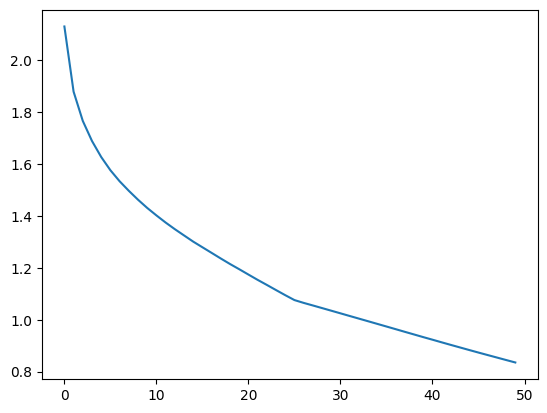

In [ ]:
# Plot the training loss
plt.plot(ls)

# Accuracy

---



```python
the following is called logits, or raw score:

[-1.2, 2.5, 0.8, -0.3, 1.1, -0.5, 0.9, 1.7, -0.2, 0.4]
  │    │    │     │    │     │    │    │     │    └── truck
  │    │    │     │    │     │    │    │     └──── ship
  │    │    │     │    │     │    │    └────── horse
  │    │    │     │    │     │    └───────── frog
  │    │    │     │    │     └──────────── dog
  │    │    │     │    └────────────── deer
  │    │    │     └──────────────── cat
  │    │    └─────────────────── bird
  │    └──────────────────── automobile (highest score: 2.5)
  └───────────────────── airplane
  ```

  argmax basically looks for the higst value and returns to you its index , in this case :
  ```
  index = 1
  ```


In [ ]:
# Evaluate the accuracy on the test set
model.eval()
correct = 0  # Initialize the number of correctly predicted samples
total = 0    # Initialize the total number of samples

# Disable gradient computation during inference
with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device('cuda:0')
      outputs = model(inputs)  # Forward pass
      predicted_labels = torch.argmax(outputs, dim=1)  # Get predicted labels by finding the index of the maximum value
      correct += torch.sum(predicted_labels == labels).item()  # Count the number of correct predictions
      total += labels.size(0)  # Update the total number of samples

accuracy = correct / total  # Calculate accuracy
print(f'Accuracy on Test Set: {accuracy * 100:.2f}%')  # Print the accuracy in percentage


Accuracy on Test Set: 50.24%


# Mispredicted  and correctly predicted labels

---




Incorrect classified samples:


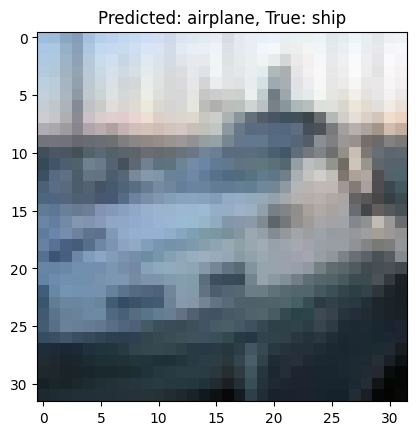

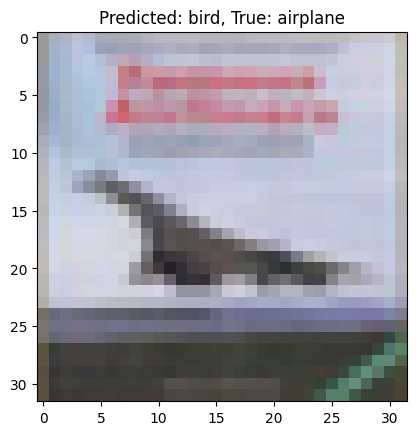

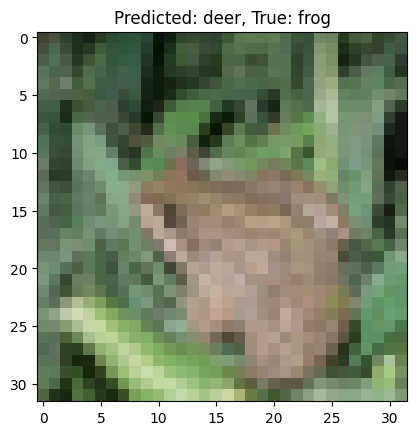


Correct classified samples:


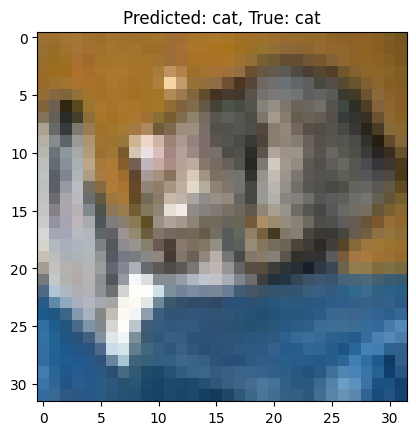

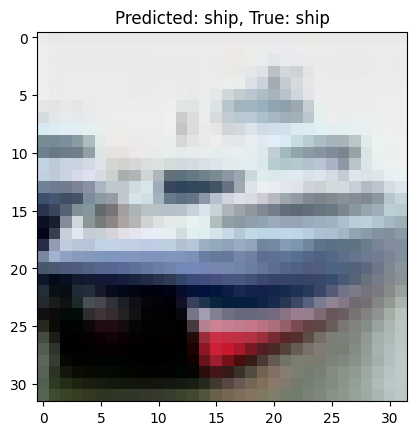

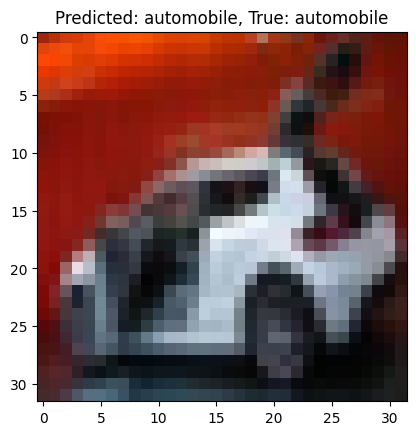

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

model.eval()
samples = {'correct': [], 'incorrect': []}

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predicted = torch.argmax(model(inputs), dim=1)

        for i, (pred, label) in enumerate(zip(predicted, labels)):
            category = 'correct' if pred == label else 'incorrect'
            samples[category].append((inputs[i], pred.item(), label.item()))

for category in ['incorrect', 'correct']:
    print(f"\n{category.capitalize()} classified samples:")
    for image, pred, true in samples[category][:3]:
        plt.imshow(T.ToPILImage()(image))
        plt.title(f'Predicted: {class_names[pred]}, True: {class_names[true]}')
        plt.show()


# Clss_wise accuracy

---



In [ ]:
# Calculate class-wise accuracy
model.eval()
class_correct = torch.zeros(10, device=device)
class_total = torch.zeros(10, device=device)

with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      predicted = torch.argmax(model(inputs), dim=1)
      for label in range(10):
        mask = (labels == label)
        class_total[label] += mask.sum()
        class_correct[label] += ((predicted == labels) & mask).sum()

for i, (correct, total) in enumerate(zip(class_correct, class_total)):
    acc = (correct / total * 100).item()
    print(f'Accuracy of class {i}: {acc:.2f}%')


Accuracy of class 0: 66.80%
Accuracy of class 1: 78.30%
Accuracy of class 2: 53.30%
Accuracy of class 3: 32.20%
Accuracy of class 4: 52.00%
Accuracy of class 5: 30.10%
Accuracy of class 6: 47.30%
Accuracy of class 7: 62.30%
Accuracy of class 8: 53.10%
Accuracy of class 9: 40.30%
